# 0. Preparación del entorno

In [1]:
import os

import uuid
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from google.colab import drive
from statsmodels.tsa.stattools import acf

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
os.environ['RUTA_SIMULACIONES'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/simulaciones/'
os.environ['RUTA_DATASETS'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/datasets/'
os.environ['DATASET_CONSUMOS'] = 'consumos_casas_1-99'
os.environ['MAX_HOUSE_LOAD'] = '99'

# 1. Arquitectura

## 1.2. Modelos

### Evento

- **reducir_extremos_serie(umbral_residuo: int = 3)**: Reduce los extremos de una serie de 2 o más minutos de duración.

  Si una serie tiene en un extremo un consumo de 1L, pero la posición contigua tiene un consumo mayor (establecido este umbral llamado como umbral residuo en >= 3L) se considera que el consumo del extremo realmente no refleja la intensidad del evento completo. Por lo tanto, extre consumo se agrega al consumo de la posición contigua, de manera que no afecte tan notablemente en el cálculo de la intensidad.

In [19]:
class Evento():
  def __init__(self, min_inicio: int, id_consumo_origen: str, serie_evento: list[int] = None):
    if serie_evento is None:
      serie_evento = []
    self.id = str(uuid.uuid4())
    self.min_inicio = min_inicio
    self.id_consumo_origen = id_consumo_origen
    self._serie = serie_evento

  def __dict__(self):
    return {
            'id': self.id,
            'id_consumo_origen': self.id_consumo_origen,
            'min_inicio': self.min_inicio,
            'min_fin': self.obtener_min_fin(),
            'serie': self._serie,
          }

  def obtener_serie(self) -> list[int]:
    return [*self._serie]

  def obtener_caracteristicas(self):
    total_vol: int = sum(self._serie)
    max_vol: int = max(self._serie)
    duracion: int = self.obtener_duracion()
    intensidad: float = total_vol / duracion
    return {
        **self.__dict__(),
        'total_vol': total_vol,
        'max_vol': max_vol,
        'duracion': duracion,
        'intensidad': intensidad
    }

  def obtener_min_fin(self) -> int:
    return self.min_inicio + len(self._serie)

  def obtener_duracion(self) -> int:
    return len(self._serie)

  def ampliar_serie_con_valor(self, valor: int):
    self._serie.append(valor)

  def ampliar_serie_con_serie(self, nueva_serie: list[int]):
    self._serie += nueva_serie

  def reducir_extremos_serie(self, umbral_residuo: int = 3):
    serie_reducida = [*self._serie]
    if len(self._serie) >= 2:
      if self._serie[0] == 1 and self._serie[1] >= umbral_residuo: # Comprobación en el primer minuto
        serie_reducida = [self._serie[0] + self._serie[1], *self._serie[2:]]
        self.min_inicio += 1
      serie_aux = [*serie_reducida[::-1]]
      if serie_aux[0] == 1 and serie_aux[1] >= umbral_residuo: # Comprobación en el último minuto
        serie_reducida = [serie_aux[0] + serie_aux[1], *serie_aux[2:]]
      serie_reducida = serie_reducida[::-1]
    self._serie = [*serie_reducida]



### Consumo

In [20]:
class Consumo:
  def __init__(self, dia: int, casa: str, parte: int = 0, serie: list[int] = []):
    self.dia: int = dia
    self.casa: str = casa
    self.parte: int = parte
    self._serie: list[int] = serie
    self._descompuesto = False
    self._lista_eventos: list[Evento] = []

  def obtener_id(self) -> str:
    id_consumo = f"{self.casa}_day{self.dia}"
    if self.parte != 0:
      id_consumo += f"_part{self.parte}"

    return id_consumo

  def obtener_serie(self) -> list[int]:
    return [*self._serie]

  def leer_serie(self):
    self._serie = leer_consumo_excel(self.dia, self.casa, self.parte)

  def obtener_lista_eac(self, consumo_minimo: int = 8) -> list[Evento]:
    lista_eac = []
    for e in self.obtener_lista_eventos():
      if sum(e.obtener_serie()) >= consumo_minimo:
        lista_eac.append(e)
    return lista_eac

  def obtener_lista_ecacld(self, duracion_minima: int = 5, intensidad_minima: int = 5) -> list[Evento]:
    lista_ecacld = []
    for e in self.obtener_lista_eac():
      if len(e.obtener_serie()) >= duracion_minima and \
        sum(e.obtener_serie()) / len(e.obtener_serie()) >= intensidad_minima:
        lista_ecacld.append(e)
    return lista_ecacld

  def obtener_lista_eccd(self, duracion_maxima: int = 4) -> list[Evento]:
    lista_eccd = []
    for e in self.obtener_lista_eac():
      if len(e.obtener_serie()) <= duracion_maxima:
        lista_eccd.append(e)
    return lista_eccd

  def obtener_lista_ebc(self, consumo_maximo: int = 7) -> list[Evento]:
    lista_ebc = []
    for e in self.obtener_lista_eventos_relevantes():
      if sum(e.obtener_serie()) <= consumo_maximo:
        lista_ebc.append(e)
    return lista_ebc

  def obtener_lista_eventos(self):
    if not self._descompuesto:
      evento = None

      for m, c in zip(range(len(self._serie)), self._serie):
        if c == 0:
          if not evento:
            continue
          else:
            evento.reducir_extremos_serie()
            self._lista_eventos.append(evento)
            evento = None
        elif c > 0:
          if not evento:
            evento = Evento(m, self.obtener_id())
          evento.ampliar_serie_con_valor(c)

      self._descompuesto = True
    return [*self._lista_eventos]

  def obtener_lista_eventos_relevantes(self, consumo_minimo_relevante: int = 2) -> list[Evento]:
    lista_eventos_relevantes = []
    for e in self.obtener_lista_eventos():
      if sum(e.obtener_serie()) >= consumo_minimo_relevante:
        lista_eventos_relevantes.append(e)
    return lista_eventos_relevantes

### Grupo Consumos

In [21]:
class GrupoConsumos:
  def __init__(self):
    self._consumos: list[Consumo] = []
    self._n_consumos = 0

  def obtener_consumos(self) -> list[Consumo]:
    return [*self._consumos]

  def obtener_consumo(self, dia: int, casa: str, parte: int = 0) -> Consumo:
    return next((c for c in self._consumos if c.dia == dia and c.casa == casa and c.parte == parte), None)

  def add_consumo(self, consumo: Consumo):
    self._consumos.append(consumo)
    self._n_consumos += 1

  def guardar_como_excel(self, nombre_archivo: str = 'consumos_casas_1-100'):
    data = []
    for consumo in self._consumos:
      data.append({
        'dia': consumo.dia,
        'casa': consumo.casa,
        'parte': consumo.parte,
        'serie': consumo.obtener_serie()
      })
    df = pd.DataFrame(data)
    df.to_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx", index=False)

  def carga_desde_excel(self, nombre_archivo: str):
    df = pd.read_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx")
    self._consumos = []
    self._n_consumos = 0
    for _, row in df.iterrows():
      consumo = Consumo(row['dia'], row['casa'], row['parte'], eval(row['serie']))
      self.add_consumo(consumo)


## 1.1. Utils

### 1.1.1. Carga y procesamiento de datos de consumo

In [22]:
def obtener_ruta_archivo(nombre: str, parte: int = 0):
  ruta_archivo = f"{os.environ.get('RUTA_SIMULACIONES')}{nombre}"
  if parte != 0:
    ruta_archivo += f"_part{parte}"
  ruta_archivo += ".xlsx"
  return ruta_archivo

assert obtener_ruta_archivo("House1", 1) == os.environ.get('RUTA_SIMULACIONES') + 'House1_part1.xlsx'
assert obtener_ruta_archivo("House1", 0) == os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx'

In [23]:
def obtener_n_dias(ruta_archivo: str):
  xls = pd.ExcelFile(ruta_archivo)
  return len([d for d in xls.sheet_names if d.startswith('Day')]);

assert obtener_n_dias(os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx') == 10

In [24]:
def leer_consumo_excel(dia: int, casa: str, parte: int = 0):
  serie = pd.read_excel(obtener_ruta_archivo(casa, parte), sheet_name=f'Day{dia}', header=None).iloc[0]
  data = [int(x) for x in serie if not isinstance(x, str)]
  return data

### 1.1.2. Visualización

In [25]:
def visualizar_serie_temporal(serie: list[int], titulo_plt: str, titulo_x: str, titulo_y: str, color: str = 'blue', figsize = (20, 5), x_inicio: int = 0, x_fin: int = 1440, x_intervalo: int = 1, x_rotacion_etiquetas: float = 90.0):
  plt.figure(figsize=figsize)
  plt.bar(range(x_inicio, x_fin), serie, color=color)
  plt.xlabel(titulo_x)
  plt.ylabel(titulo_y)
  plt.title(titulo_plt)
  plt.xticks(range(x_inicio, x_fin, x_intervalo), rotation=x_rotacion_etiquetas)
  plt.show()

### 1.1.2. Tratamiento de eventos

In [26]:
def construir_dataset_eventos(lista_eventos: list[Evento]):
  filas = []
  for e in lista_eventos:
    filas.append(e.obtener_caracteristicas())

  return pd.DataFrame(filas).set_index('id')

In [27]:
def construir_serie_desde_eventos(lista_eventos: list[Evento], acotada: bool = True):
  if not lista_eventos:
    return [0] * 1440

  lista_eventos.sort(key=lambda evento: evento.min_inicio)
  ultimo_evento = lista_eventos[0]
  serie = [*ultimo_evento.obtener_serie()]

  for e in lista_eventos[1:]:
    if ultimo_evento.obtener_min_fin() <= e.min_inicio:
      serie += [0] * (e.min_inicio - ultimo_evento.obtener_min_fin())
      serie += e.obtener_serie()
      ultimo_evento = e
    else:
      pass

  if not acotada:
    serie = [*([0] * lista_eventos[0].min_inicio), *serie, *([0] * (1440 - lista_eventos[::-1][0].obtener_min_fin()))]

  return serie


### 1.1.3. Localización de eventos discontinuos

In [28]:
def calcular_autocorrelacion(serie: list[int], nlags: int, lags_offset: int = 3):
  autocorrelacion, intervalo_confianza = acf(serie, nlags=nlags, alpha=0.05)
  autocorrelacion = autocorrelacion[lags_offset:]
  intervalo_confianza = intervalo_confianza[lags_offset:]

  return (autocorrelacion, intervalo_confianza)

In [29]:
def calcular_umbral_lower(intervalo_confianza: np.array):
  lowers = []
  for lower, upper in intervalo_confianza:
    lowers.append(lower)

  media_lowers = np.mean(lowers)
  umbral_lower = media_lowers + np.std(lowers)
  return umbral_lower

In [30]:
def localizar_repeticiones(serie: list[int], min_inicio: int, umbral_separacion_ecd: int, lags_offset: int = 3):
  autocorrelacion, intervalo_confianza = calcular_autocorrelacion(serie, len(serie) - 1)
  umbral_lower = calcular_umbral_lower(intervalo_confianza)

  repeticiones = []
  distancia_ultima_repeticion = lags_offset - 1
  for lag, val, (lower, upper) in zip(range(lags_offset, len(autocorrelacion) + lags_offset), autocorrelacion, intervalo_confianza):
    distancia_ultima_repeticion += 1
    if lower > umbral_lower and distancia_ultima_repeticion > umbral_separacion_ecd:
      repeticiones.append((lag + min_inicio, distancia_ultima_repeticion))
      distancia_ultima_repeticion = 0

  return repeticiones


# 2. Main

### Generación o lectura del dataset con todas las series temporales de consumo

In [31]:
consumos_simulados = GrupoConsumos()
dataset_consumos = os.environ.get('DATASET_CONSUMOS')

if dataset_consumos == '':
  for i in range(1, int(os.environ.get('MAX_HOUSE_LOAD')) + 1):
    casa = f"House{i}"
    for d in range(1, obtener_n_dias(obtener_ruta_archivo(casa)) + 1):
      consumo = Consumo(d, casa)
      consumo.leer_serie()
      consumos_simulados.add_consumo(consumo)
  consumos_simulados.guardar_como_excel(f"consumos_casas_1-{os.environ.get('MAX_HOUSE_LOAD')}")
else:
  consumos_simulados.carga_desde_excel(dataset_consumos)

### Representación gráfica de la serie temporal

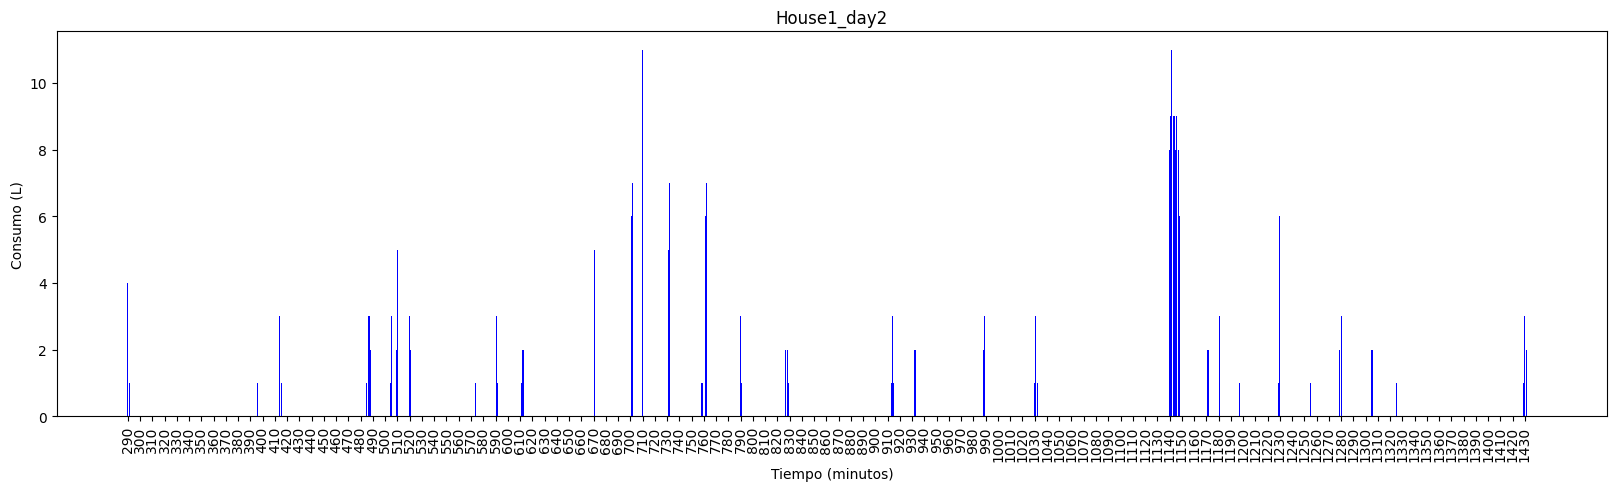

In [32]:
consumo_ejemplo = next(consumo for consumo in consumos_simulados.obtener_consumos() if max(consumo.obtener_serie()) > 7 and sum(consumo.obtener_serie()) > 150)
consumo_ejemplo = consumos_simulados.obtener_consumo(1, "House10")
consumo_ejemplo = consumos_simulados.obtener_consumos()[1]

inicio = 290
fin = 1440
serie_ejemplo = consumo_ejemplo.obtener_serie()[inicio:fin]

visualizar_serie_temporal(serie_ejemplo, consumo_ejemplo.obtener_id(), 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10, )


## División en alto consumo y bajo consumo

### Tratamiento de alto consumo

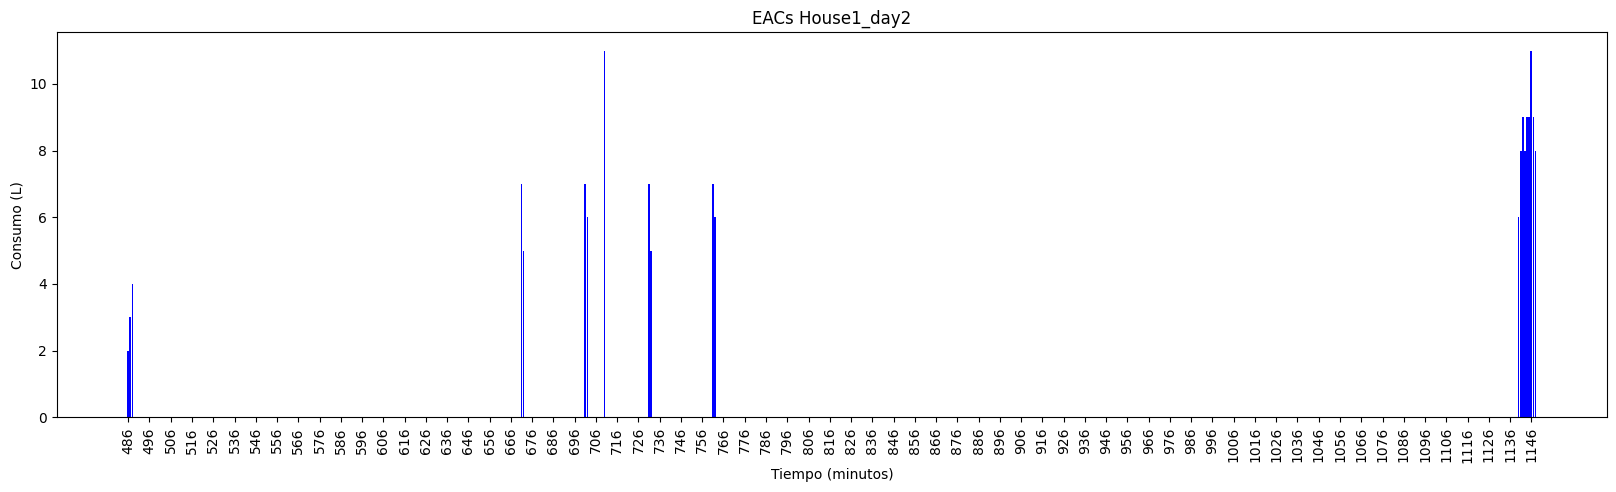

In [33]:
eventos = consumo_ejemplo.obtener_lista_eac()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'EACs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

#### Extracción de eventos continuos de alto consumo y de larga duración

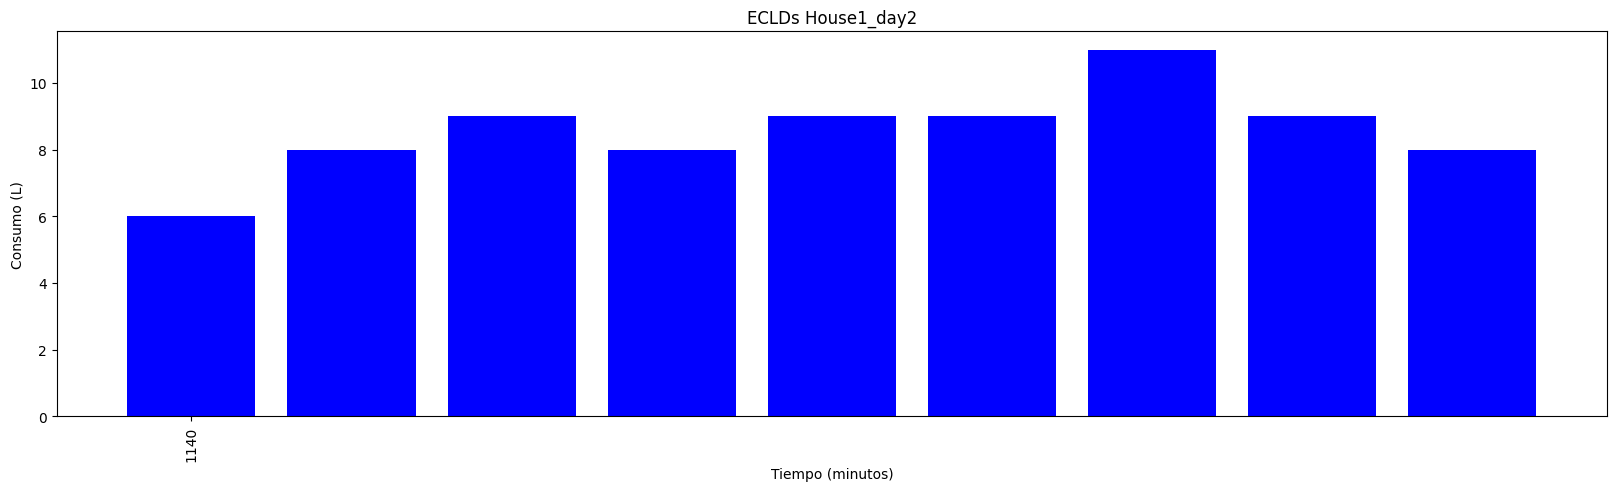

In [34]:
eventos = consumo_ejemplo.obtener_lista_ecacld()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'ECLDs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

#### Extracción de eventos continuos de corta duración

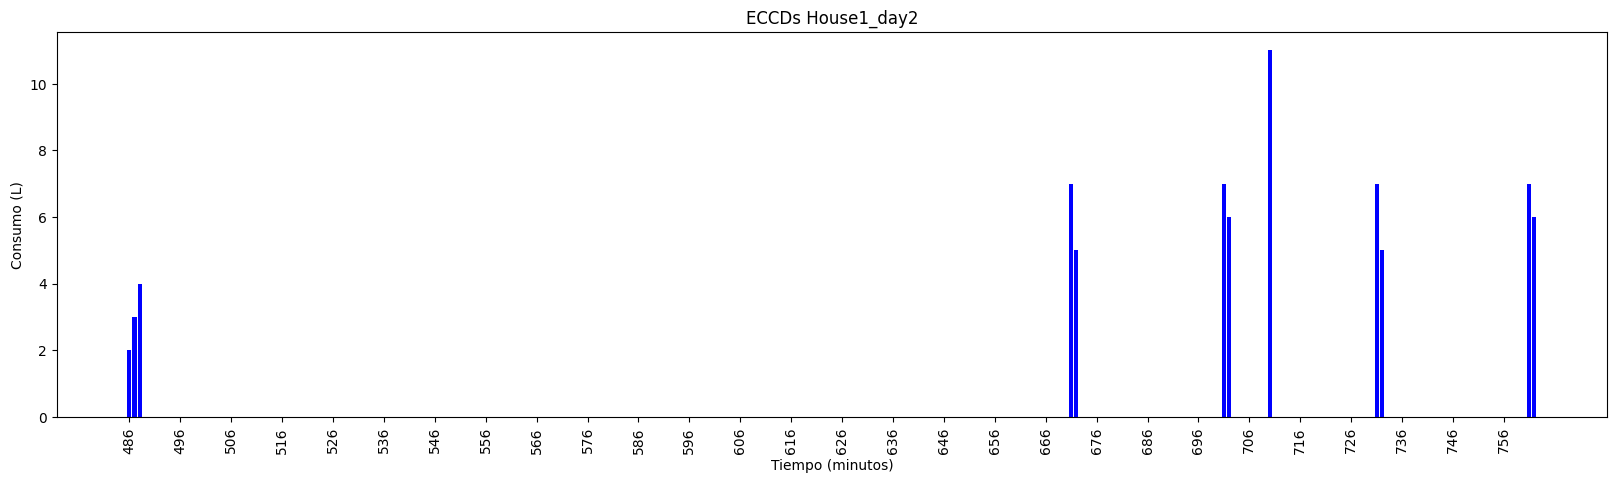

In [35]:
eventos = consumo_ejemplo.obtener_lista_eccd()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'ECCDs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

### Tratamiento de bajo consumo

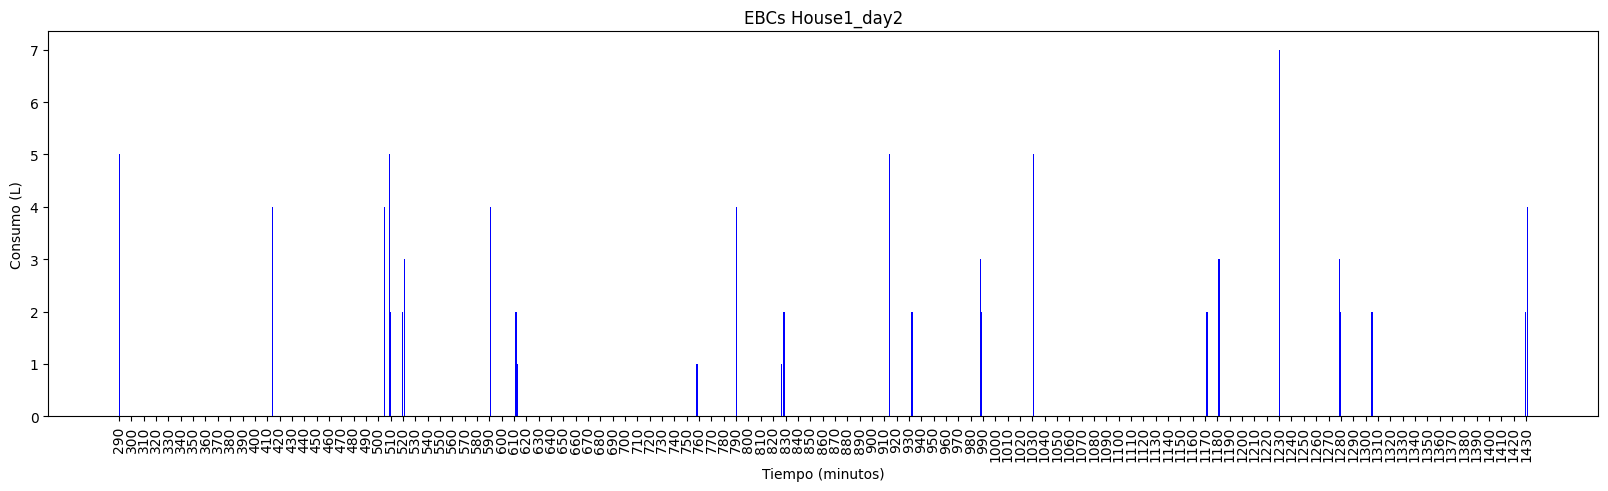

In [36]:
eventos = consumo_ejemplo.obtener_lista_ebc()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'EBCs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

In [37]:
construir_dataset_eventos(eventos)

,id_consumo_origen,min_inicio,min_fin,serie,total_vol,max_vol,duracion,intensidad
id,,,,,,,,
903756f1-51a9-475b-a295-503c257a8aae,House1_day2,290,291,[5],5,5,1,5.000000
d29069e9-3cb4-47b6-b58e-fd2a24b55eee,House1_day2,414,415,[4],4,4,1,4.000000
f4dd0baf-1a8d-4a64-bb6f-75529b511e11,House1_day2,505,506,[4],4,4,1,4.000000
9656ac1c-00d0-4f91-b028-a325ff8231f8,House1_day2,509,511,"[5, 2]",7,5,2,3.500000
1a8ffe00-ba15-48a1-a51c-4c42ab59249b,House1_day2,520,522,"[2, 3]",5,3,2,2.500000
a8ed06f0-34b5-467f-bd48-783c94b381c0,House1_day2,591,592,[4],4,4,1,4.000000
0f58d9f9-1fcc-4601-bda2-75b5cb435436,House1_day2,611,614,"[2, 2, 1]",5,2,3,1.666667
53187373-e18b-48d0-8449-a64b839328e4,House1_day2,758,760,"[1, 1]",2,1,2,1.000000
f4efaf3e-6099-495e-9a67-4854092f556c,House1_day2,790,791,[4],4,4,1,4.000000


# Code testing

In [ ]:
localizar_repeticiones(serie_ejemplo, 0, 10)

[(21, 21), (38, 17), (51, 13), (89, 38), (275, 186)]

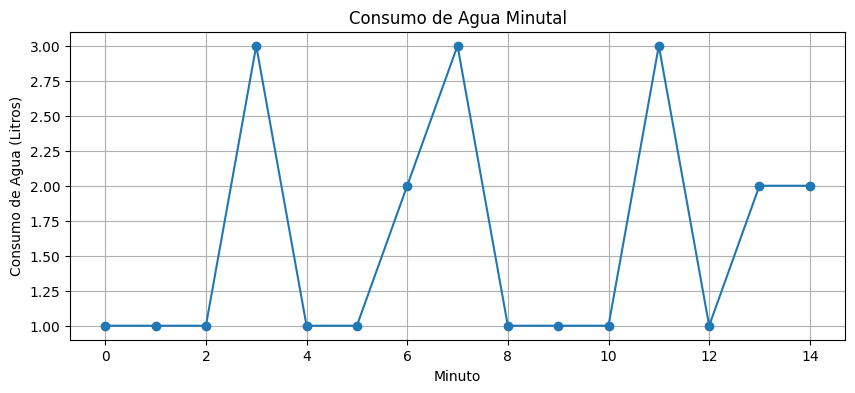

<Figure size 1000x400 with 0 Axes>

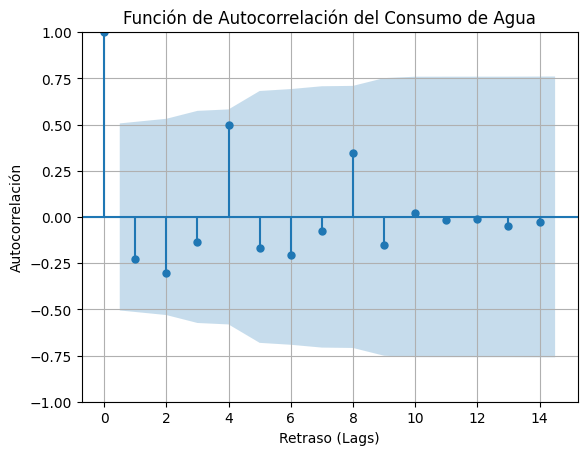

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

serie_ejemplo = [1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 1, 3, 1, 2, 2]
inicio = 0
fin = len(serie_ejemplo)

plt.figure(figsize=(10, 4))
plt.plot(serie_ejemplo, marker='o')
plt.title('Consumo de Agua Minutal')
plt.xlabel('Minuto')
plt.ylabel('Consumo de Agua (Litros)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(serie_ejemplo, lags=(fin - inicio - 1))
plt.title('Función de Autocorrelación del Consumo de Agua')
plt.xlabel('Retraso (Lags)')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()



In [ ]:
localizar_repeticiones(serie_ejemplo, 0, 10)

[]

In [ ]:
from statsmodels.tsa.stattools import acf
autocorr, conf_int = acf(serie_ejemplo, nlags=(fin - inicio - 1), alpha=0.05)
lowers = []
for lower, upper in conf_int[3:]:
  lowers.append(lower)
media_lowers = np.mean(lowers)
umbral_significativo = media_lowers + np.std(lowers)  # Umbral basado en la media y desviación estándar
print(umbral_significativo)

-0.4762921770150438


In [ ]:
print("Autocorrelación e Intervalos de Confianza:")
for lag, val, (lower, upper) in zip(range(len(autocorr)), autocorr, conf_int):
    print(f"Lag {lag}: {val:.3f}, Intervalo de Confianza: ({lower:.3f}, {upper:.3f})")

Autocorrelación e Intervalos de Confianza:
Lag 0: 1.000, Intervalo de Confianza: (1.000, 1.000)
Lag 1: -0.225, Intervalo de Confianza: (-0.731, 0.281)
Lag 2: -0.304, Intervalo de Confianza: (-0.835, 0.227)
Lag 3: -0.133, Intervalo de Confianza: (-0.707, 0.441)
Lag 4: 0.496, Intervalo de Confianza: (-0.086, 1.078)
Lag 5: -0.167, Intervalo de Confianza: (-0.848, 0.515)
Lag 6: -0.204, Intervalo de Confianza: (-0.896, 0.488)
Lag 7: -0.075, Intervalo de Confianza: (-0.782, 0.632)
Lag 8: 0.346, Intervalo de Confianza: (-0.363, 1.055)
Lag 9: -0.150, Intervalo de Confianza: (-0.901, 0.601)
Lag 10: 0.021, Intervalo de Confianza: (-0.738, 0.780)
Lag 11: -0.017, Intervalo de Confianza: (-0.776, 0.742)
Lag 12: -0.012, Intervalo de Confianza: (-0.771, 0.746)
Lag 13: -0.050, Intervalo de Confianza: (-0.809, 0.709)
Lag 14: -0.025, Intervalo de Confianza: (-0.785, 0.735)


In [ ]:
# Decisión sobre la repetición basada en la autocorrelación
def hay_repeticion(autocorr, umbral=0.2):
    for lag, val in enumerate(autocorr):
        if lag != 0 and abs(val) > umbral:
            return True, lag
    return False, None

umbral_autocorrelacion = 0.2
repeticion, lag = hay_repeticion(autocorr, umbral_autocorrelacion)

if repeticion:
    print(f"Se detectó una repetición significativa en el lag {lag}.")
else:
    print("No se detectaron repeticiones significativas.")


Se detectó una repetición significativa en el lag 1.


# Series Reales

In [ ]:
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 4, 2, 1, 4, 2, 6, 2, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 6, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 4, 5, 3, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 3, 1, 0, 0, 0, 0, 0, 0, 5, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 6, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

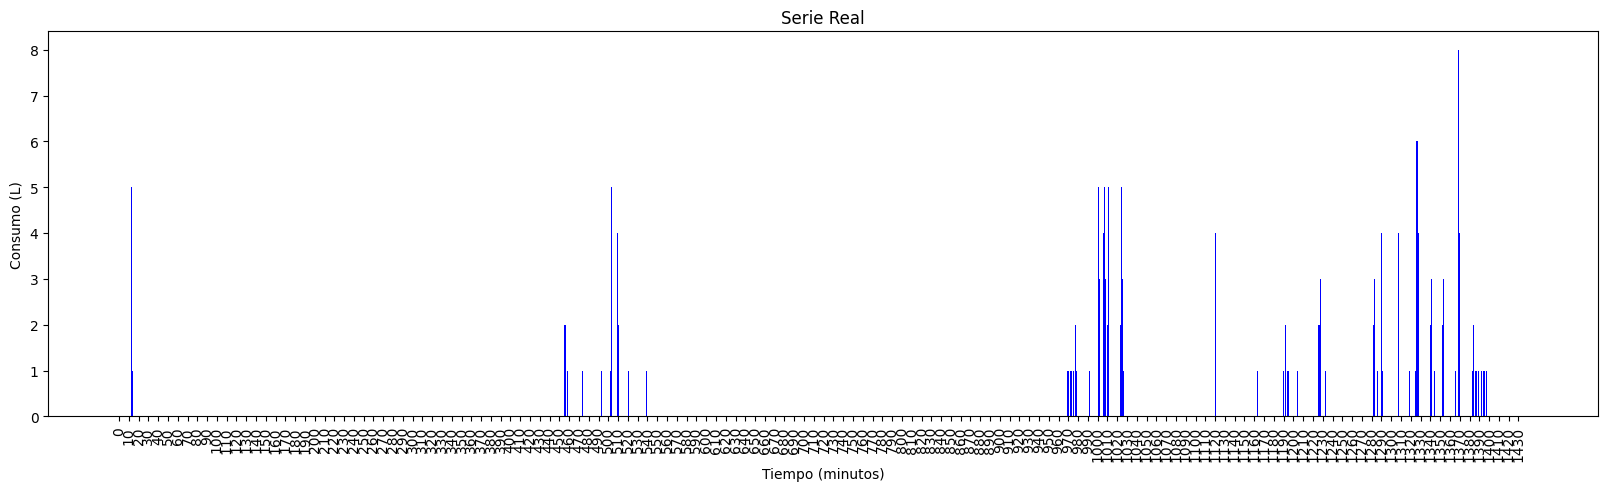

In [ ]:
visualizar_serie_temporal(serie_real, f'Serie Real', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = 0, x_fin = 1440, x_intervalo = 10)

In [ ]:
consumo_real = Consumo(0, '44803', serie = serie_real)

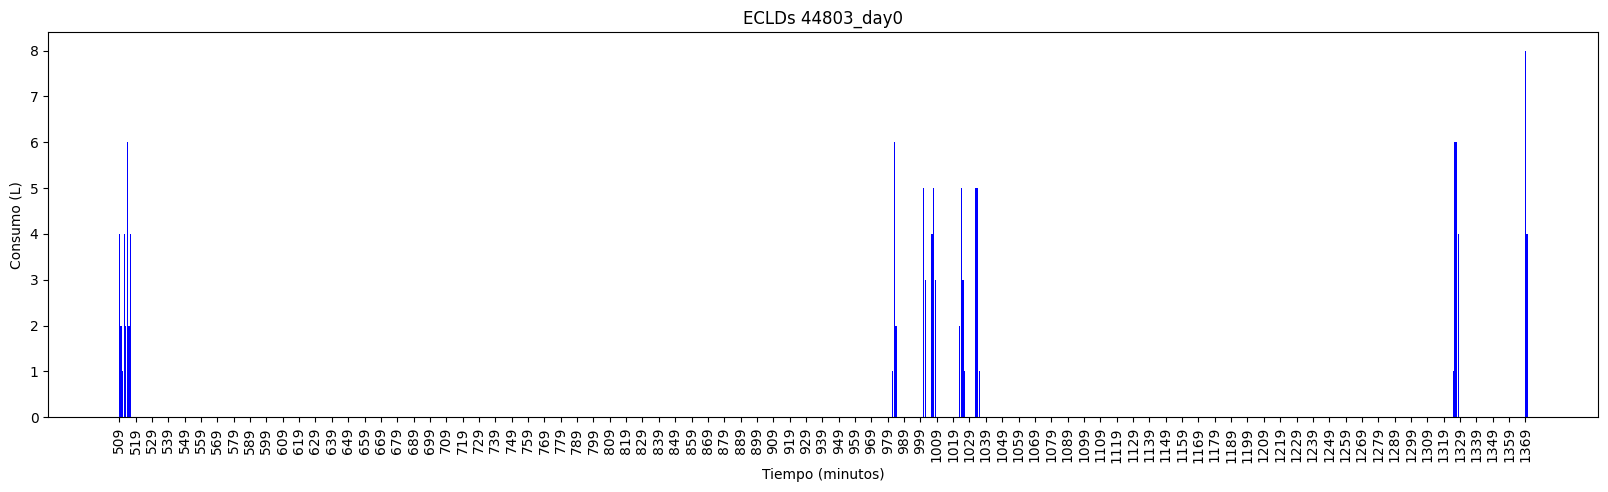

In [ ]:
eventos = consumo_real.obtener_lista_eac()

acotada = True
serie_reconstruida = construir_serie_desde_eventos(eventos, acotada)
if not acotada:
  inicio = 0
  fin = 1440
else:
  inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
  fin = len(serie_reconstruida) + inicio

visualizar_serie_temporal(serie_reconstruida, f'ECLDs {consumo_real.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

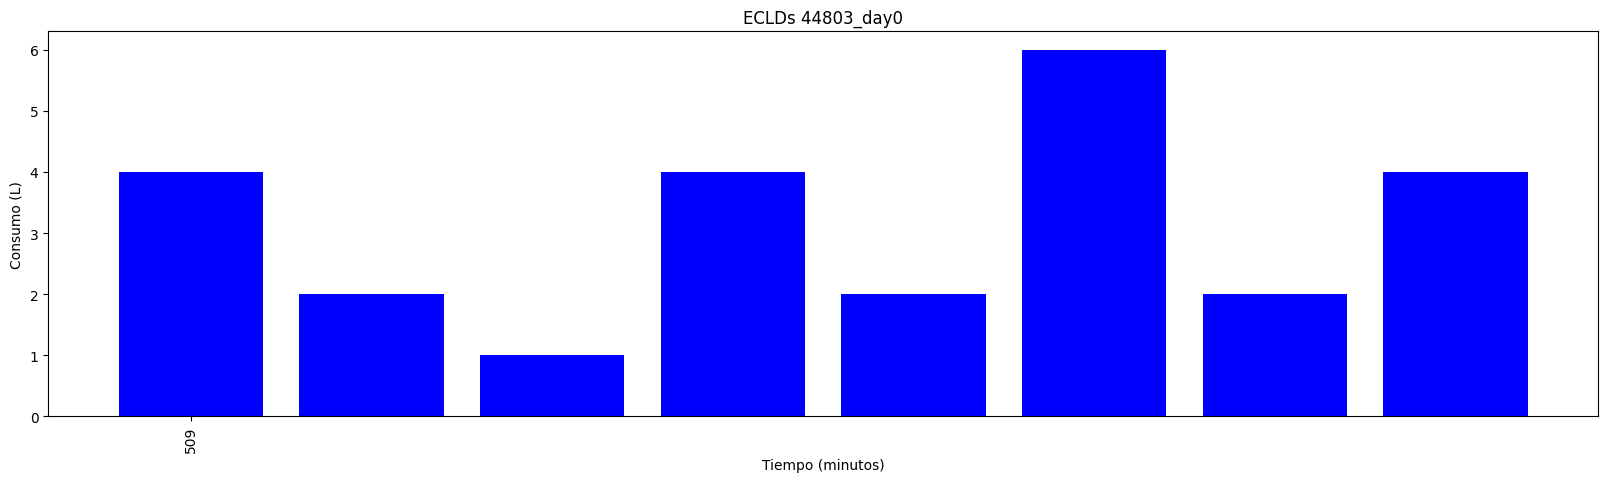

In [ ]:
eventos = consumo_real.obtener_lista_ecld()

acotada = True
serie_reconstruida = construir_serie_desde_eventos(eventos, acotada)
if not acotada:
  inicio = 0
  fin = 1440
else:
  inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
  fin = len(serie_reconstruida) + inicio

visualizar_serie_temporal(serie_reconstruida, f'ECLDs {consumo_real.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

In [ ]:
construir_dataset_eventos(eventos)

,id_consumo_origen,min_inicio,min_fin,serie,total_vol,max_vol,duracion,intensidad
id,,,,,,,,
646a1970-01ba-4ea0-9028-12646c186b65,44803_day0,509,517,"[4, 2, 1, 4, 2, 6, 2, 4]",25,6,8,3.125000
976edd68-d30a-4d40-a082-675e36a9d1c0,44803_day0,982,985,"[1, 6, 2]",9,6,3,3.000000
d6ed12ff-8826-4d9e-8dfd-cee18190b1f3,44803_day0,1001,1003,"[5, 3]",8,5,2,4.000000
3138f6da-8833-42d1-9cb3-9133793b522f,44803_day0,1006,1009,"[4, 5, 3]",12,5,3,4.000000
a77d9187-236a-41ad-b2cd-5d8486fb1e18,44803_day0,1023,1027,"[2, 5, 3, 1]",11,5,4,2.750000
3aecc5f3-79bd-4f83-980f-8e28ff381bd8,44803_day0,1033,1036,"[5, 5, 1]",11,5,3,3.666667
b4d5645a-1df7-4e84-9160-c111c9bfaaa1,44803_day0,1325,1329,"[1, 6, 6, 4]",17,6,4,4.250000
bc4444de-8194-4496-b796-381cff26adc6,44803_day0,1369,1371,"[8, 4]",12,8,2,6.000000


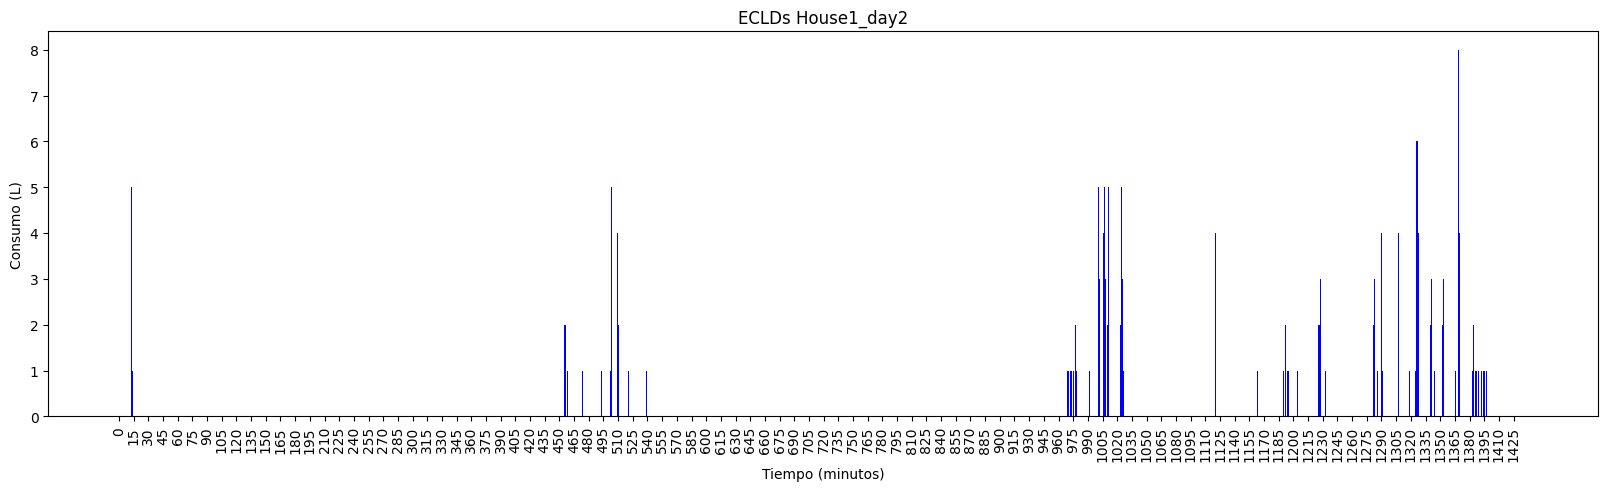

In [ ]:
inicio = 0
fin = 1440
visualizar_serie_temporal(serie_real, f'ECLDs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 15)

In [ ]:
localizar_repeticiones(serie_real[1282:fin], 0, 10)

[(14, 14), (25, 11), (41, 16), (61, 20), (79, 18)]

In [ ]:
serie_consumo = []
ultimo_min_fin = 0
for e in serie_eventos:
  serie_consumo += [0]*(e["start"] - ultimo_min_fin) + e["serie"]
  ultimo_min_fin = e["end"] + 1
serie_consumo += [0]* (1440 - ultimo_min_fin)
print(serie_consumo)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# NOTAS

- Para que haya discontinuidad en un evento continuo el consumo debe ser menor a 1 L/minuto.
- No es de interés identificar los consumos de menos de 1 L/minuto.
- Primera pasada: obtener todos los eventos entre c = 0.
- Cuando un evento tiene n minutos de duración, siendo n >= 2, y el primero o el último de ellos es de 1L mientras que el anterior es de más de 3, lo más probable es que ese litro restante sea residual, por lo que se suma al consumo del anterior minuto en caso de que sea el último minuto o del siguiente en caso de que sea el primer minuto.

## Tipos de eventos

- **Continuos de alto consumo y larga duración**: Duración >= 5 & Volumen >= 25 & Intensidad > 5 (bañera, ducha)
- **Continuos de corta duración**: Duración < 5 (grifo, wc)
- **Discontinuos de larga duración**: Duración >= 45 & Volumen >= 10 & Repeticiones de ECDs >= 2 (lavadora, lavavajillas)
- **Discontinuo de baja duración**: Intensidad < 1 L/min (llenado de vaso de agua, eventos con muy bajo consumo. Se desprecian).
- ***Continuos dependientes**: Componen los eventos DLD (descargas de lavadora o lavavajillas)